In [ ]:
import os
import sys
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import random

sys.path.append(os.path.abspath(os.path.join("../..")))
from src.datasets.huggingfacefilelistdataset import HuggingFaceFileListDataset  # noqa: E402
from src.datasets.kaggledataset import KaggleDataset  # noqa: E402
from src.models.crnn.crnn_v1 import Captcha_CRNN_V1

# Evaluate V2 on Kaggle Dataset

In [2]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        # transforms.RandomInvert(p=0.5),
        # transforms.RandomRotation(5),
        transforms.ToTensor(),
    ]
)
dataset = KaggleDataset(os.environ["KAGGLE_ROOT_DIR"], transform=captcha_transformation, preload=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Captcha_CRNN_V1(num_chars=len(dataset.vocab) + 1)
state_dict = torch.load(Captcha_CRNN_V1.SAVE_DIR / "v2.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval() 

print(f"Model successfully loaded from {Captcha_CRNN_V1.SAVE_DIR / "v2.pth"}")


Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/crnn/v2.pth


In [4]:
def decode_predictions(logits, dataset):
    tokens = torch.argmax(logits, dim=-1)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

In [5]:
def visualize_single_prediction_kaggle(model, dataset, device):
    model.eval()

    idx = random.randrange(len(dataset))
    image, label = dataset[idx]   # dataset __getitem__

    image = image.unsqueeze(0).to(device)  # add batch dim: (1, C, H, W)

    with torch.no_grad():
        logits = model(image)

    pred_str = decode_predictions(logits[0], dataset)

    actual_indices = [v.item() for v in label if v.item() != 0]
    actual_str = "".join(dataset.idx_to_char[v] for v in actual_indices)

    img = image[0].cpu().squeeze().numpy()

    plt.figure(figsize=(6, 3))
    plt.imshow(img, cmap="gray")
    color = "green" if pred_str == actual_str else "red"
    plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
    plt.axis("off")
    plt.show()

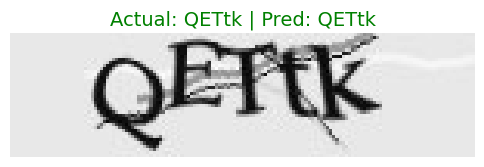

In [13]:
visualize_single_prediction_kaggle(model, dataset, device)

# Evaluate V2 on Hugging-Face Test Dataset

In [ ]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((40, 150)),
        transforms.ToTensor(),
    ]
)
dataset = HuggingFaceFileListDataset(
    file_list="test_file_list_crnn.txt",
    transform=captcha_transformation
)

In [15]:
def visualize_single_prediction_hf(model, dataset, device):
    model.eval()

    idx = random.randrange(len(dataset))
    image, label, _ = dataset[idx]   # dataset __getitem__

    image = image.unsqueeze(0).to(device)  # add batch dim: (1, C, H, W)

    with torch.no_grad():
        logits = model(image)

    pred_str = decode_predictions(logits[0], dataset)

    actual_indices = [v.item() for v in label if v.item() != 0]
    actual_str = "".join(dataset.idx_to_char[v] for v in actual_indices)

    img = image[0].cpu().squeeze().numpy()

    plt.figure(figsize=(6, 3))
    plt.imshow(img, cmap="gray")
    color = "green" if pred_str == actual_str else "red"
    plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
    plt.axis("off")
    plt.show()

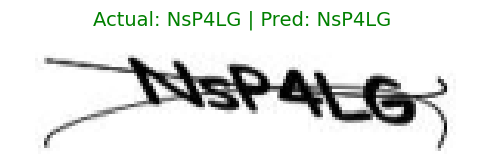

In [66]:
visualize_single_prediction_hf(model, dataset, device)

In [99]:
# TODO: Maybe try different Augmentation Techniques (maybe even custom shapes drawn on top of it) for further improvement and generalization
# TODO: Try to optimize training time
# TODO: Filter out black images
# TODO: Letter-wise confusion matrix
# TODO: Auto-Encoder to detect images which are no CAPTCHA's